Imports.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from numpy import sinh, cosh
import time 

import numba
from numba import njit

Testing TF, GPU drivers and ROCm support.

In [2]:
import tensorflow as tf
# because of tf version many warnings will occur
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import deepxde as dde

print('TF version: {}'.format(tf.__version__))
print('GPU support enabled: {}'.format(tf.test.is_built_with_gpu_support()))
print('ROCm support enabled: {}'.format(tf.test.is_built_with_rocm()))

TF version: 1.15.0
GPU support enabled: True
ROCm support enabled: True


# 1D Bioheat transfer time-invariant equation

Time-variant 1D Pennes equation:

$$
\nabla(k \nabla T) + Q_b + Q_m + Q_{ext} = c_v \rho \frac{\partial T}{\partial t}
$$

where $Q_b = w_b \cdot T_a - w_b \cdot T$.

Time-invariant form:

$$
k \cdot \frac{d^2 T}{d x^2} - w_b \cdot T(x) + w_b \cdot T_a + Q_m + Q_{ext} = 0
$$

Boundary conditions:

**Dirichlet** $$
T_0(x) = T_c \hspace{10mm} x=L;
$$

**Robins** $$
-k \frac{dT_0(x)}{dx}=h_0[T_f - T_0(x)] \hspace{10mm} x=0.
$$

Calculations for no external source of heating, $Q_{ext} = 0$.

In [39]:
# consts 
c_b = 4200 
rho_b = 1e3 
om_b = 5e-4
c = 4200 
h_f = 100;
T_c = 37
L = 3e-2

# random variables
k = 0.5
w_b = c_b*rho_b*om_b
Q_m = 33800
h_0 = 10
T_f = 25
T_a = 37
rvs = [k, w_b, T_a, Q_m, h_0, T_f]
rvs = np.array(rvs).reshape(1, -1)

# solution domain
x = np.linspace(0, L, num=49)

Analytical solution.

In [40]:
def analyticSol(x):
    A = np.sqrt(w_b/k)
    lterm = (T_c - T_a - Q_m/w_b) * (A * cosh(A * x)  +\
                +  (h_0/k) * sinh(A * x)) / (A * cosh(A * L) + (h_0/k) * sinh(A * L))
    rterm = h_0/k * (T_f - T_a - Q_m/w_b) * sinh(A * (L * np.ones(shape=x.shape) - x)) / ( A * cosh(A * L) + (h_0/k) * sinh(A * L)) 

    return  T_a + Q_m/w_b + lterm + rterm

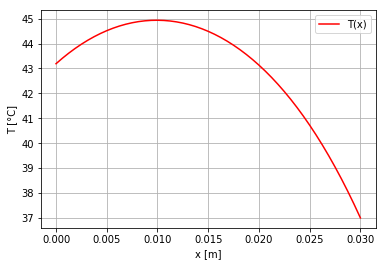

In [42]:
T_anal = analyticSol(x)
plt.plot(x, T_anal, 'r-', label='T(x)')
plt.xlabel('x [m]')
plt.ylabel('T [°C]')
plt.grid()
plt.legend(loc='best')
plt.show()

Monte Carlo simulation.

In [26]:
@njit
def monteCarloSim(x, rvs, coef_var=0.2, num_samples=1000, num_iters=1000):
    sims_global = np.empty(shape=(num_iters, num_samples, rvs.shape[1]))
    for i in range(num_iters):
        xi = np.random.rand(num_samples, len(rvs)) # random values
        sims = np.zeros(shape=xi.shape)            # empty simulations matrix
        
        rvs_min = rvs - coef_var*rvs              
        rvs_max = rvs + coef_var*rvs

        sims = rvs_min + (rvs_max - rvs_min) * xi
        sims_global[i, :, :] = sims
    return sims_global

@njit
def monteCarloT(x, K, w_b, T_a, Q_m, h_0, T_f):
    A = np.sqrt(w_b/K)
    lterm = (T_c - T_a - Q_m/w_b) * (A * cosh(A * x)  +\
                +  (h_0/K) * sinh(A * x)) / (A * cosh(A * L) + (h_0/K) * sinh(A * L))
    rterm = h_0/K * (T_f - T_a - Q_m/w_b) * sinh(A * (L * np.ones(shape=x.shape) - x)) / ( A * cosh(A * L) + (h_0/K) * sinh(A * L)) 

    return T_a + Q_m/w_b + lterm + rterm

@njit
def monteCarloResample(x, mc):
    num_iters, num_samples, n_rv = mc.shape
    
    T_mc = np.empty(shape=(num_iters, num_samples, x.shape[0]))
    
    for it in range(num_iters):
        for sample in range(num_samples):
            T_mc[it, sample, :] = monteCarloT(x, mc[it, sample, 0], mc[it, sample, 1], mc[it, sample, 2], mc[it, sample, 3], mc[it, sample, 4], mc[it, sample, 5])
    return T_mc

In [27]:
num_samples = 1000
num_iters = 100
coef_var = 0.2

start = time.time()
mc = monteCarloSim(x, rvs, coef_var, num_samples, num_iters)
T_mc = monteCarloResample(x, mc)
print('Simulation time: {}s'.format(time.time() - start))

Simulation time: 1.1748926639556885s


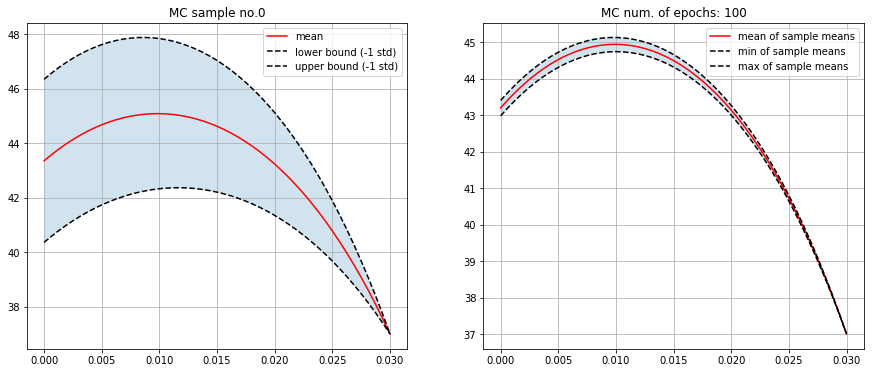

In [28]:
plt.figure(figsize=(15,6))

# single sample
_sample_exmp = 0
T_mc0 = T_mc[_sample_exmp]
T_mc0_mean = np.mean(T_mc0, axis=0)
T_mc0_std = np.std(T_mc0, axis=0)
T_mc0_lower_bound = T_mc0_mean - T_mc0_std
T_mc0_upper_bound = T_mc0_mean + T_mc0_std

plt.subplot(1,2,1)
plt.plot(x, T_mc0_mean, 'r-', label='mean')
plt.plot(x, T_mc0_lower_bound, 'k--', label='lower bound (-1 std)')
plt.plot(x, T_mc0_upper_bound, 'k--', label='upper bound (-1 std)')
plt.fill_between(x, T_mc0_lower_bound, T_mc0_upper_bound, alpha=0.2)
plt.legend(loc='best')
plt.title('MC sample no.{}'.format(_sample_exmp))
plt.grid()

# full simulation
T_mc_mean = np.mean(T_mc, axis=1)
T_mean = np.mean(T_mc_mean, axis=0)
T_std = np.std(T_mc_mean, axis=0)
T_lower_bound = T_mc_mean[np.argmin(T_mc_mean[:, 0], axis=0)]
T_upper_bound = T_mc_mean[np.argmax(T_mc_mean[:, 0], axis=0)]

plt.subplot(1,2,2)
plt.plot(x, T_mean, 'r-', label='mean of sample means')
plt.plot(x, T_lower_bound, 'k--', label='min of sample means')
plt.plot(x, T_upper_bound, 'k--', label='max of sample means')
plt.fill_between(x, T_lower_bound, T_upper_bound, alpha=0.2)
plt.legend(loc='best')
plt.title('MC num. of epochs: {}'.format(num_iters))
plt.grid()

plt.show()

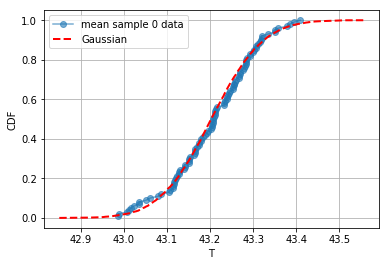

In [29]:
# distribution of sample means
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

_exmp = 0
x_cdf, y_cdf = ecdf(T_mc_mean[:, _exmp])
plt.plot(x_cdf, y_cdf, marker='o', alpha=0.6, label='mean sample 0 data')

samples = np.random.normal(np.mean(T_mc_mean[:, _exmp]), np.std(T_mc_mean[:, _exmp]), 10000)
x_theor, y_theor = ecdf(samples)
plt.plot(x_theor, y_theor, 'r--', linewidth=2, label='Gaussian')

plt.xlabel('T')
plt.ylabel('CDF')
plt.grid()
plt.legend(loc='best')
plt.show()

FEM.

In [30]:
def assemble_l(lhss, lhs_glob):
    if lhs_glob.shape[0]!=lhs_glob.shape[1]:
        raise Exception("Global matrix is not square matrix!") 
    else:
        for i, lhs in enumerate(lhss):
            lhs_glob[i:i+lhs.shape[0], i:i+lhs.shape[1]] += lhs
    return lhs_glob    

def assemble_r(rhss, rhs_glob):
    for i, rhs in enumerate(rhss):
        rhs_glob[i:i+rhs.shape[0], ] += rhs
    return rhs_glob

In [31]:
# domain
L = 3e-2
x = np.linspace(0, L, 100)

# fem
N = 10 # number of elements

# solution
lhs_glob = np.zeros((N+1, N+1))
T = np.zeros((N+1, 1))
rhs_glob = np.zeros((N+1, 1))

In [32]:
# base function combinations
n1 = lambda x, a, b: (w_b*T_a + Q_m) * (b-x)/(b-a)
n2 = lambda x, a, b: (w_b*T_a + Q_m) * (x-a)/(b-a)

nn11 = lambda x, a, b: w_b * ((b-x)/(b-a))**2
nn12 = lambda x, a, b: w_b * ((x-a)*(b-x))/((b-a)**2)
nn21 = lambda x, a, b: w_b * ((x-a)*(b-x))/((b-a)**2)
nn22 = lambda x, a, b: w_b * ((x-a)/(b-a))**2

nn_x11 = lambda x, a, b:  k/((b-a)**2)
nn_x12 = lambda x, a, b:  -k/((b-a)**2)
nn_x21 = lambda x, a, b:  -k/((b-a)**2)
nn_x22 = lambda x, a, b:  k/((b-a)**2)

In [33]:
a = 0
dx = L/N
b = dx
lhs = np.zeros((2, 2))
rhs = np.zeros((2, 1))
lhss = []
rhss = []
for i in range(N):
    print('{}. element: integration domain [{}, {}]'.format(i+1, a, b))
    lhs[0,0] = -(quad(nn11, a, b, args=(a, b))[0] + quad(nn_x11, a, b, args=(a, b))[0])
    lhs[0,1] = -(quad(nn12, a, b, args=(a, b))[0] + quad(nn_x12, a, b, args=(a, b))[0])
    lhs[1,0] = -(quad(nn21, a, b, args=(a, b))[0] + quad(nn_x21, a, b, args=(a, b))[0])
    lhs[1,1] = -(quad(nn22, a, b, args=(a, b))[0] + quad(nn_x22, a, b, args=(a, b))[0])
    lhss.append(lhs)
    
    rhs[0, 0] = -(quad(n1, a, b, args=(a, b))[0])
    rhs[1, 0] = -(quad(n2, a, b, args=(a, b))[0])
    rhss.append(rhs)
    
    a = a + dx
    b = b + dx

1. element: integration domain [0, 0.003]
2. element: integration domain [0.003, 0.006]
3. element: integration domain [0.006, 0.009000000000000001]
4. element: integration domain [0.009000000000000001, 0.012]
5. element: integration domain [0.012, 0.015]
6. element: integration domain [0.015, 0.018]
7. element: integration domain [0.018, 0.020999999999999998]
8. element: integration domain [0.020999999999999998, 0.023999999999999997]
9. element: integration domain [0.023999999999999997, 0.026999999999999996]
10. element: integration domain [0.026999999999999996, 0.029999999999999995]


In [34]:
# assemble in global matrices
lhs_glob = assemble_l(lhss, lhs_glob)
rhs_glob = assemble_r(rhss, rhs_glob)

In [35]:
# boundary conds
# DBC
T[-1, 0] = T_c                   
lhs_glob = lhs_glob[:-1, :-1]
rhs_glob = rhs_glob[:-1, ]

In [36]:
# RBC
lhs_glob[0, 0] -= h_0            
rhs_glob[0, 0] -= h_0 * T_f
rhs_glob[-1, 0] -= T_c * lhs_glob[-1, -2] 

In [37]:
T[:-1, ] = np.linalg.inv(lhs_glob) @ rhs_glob

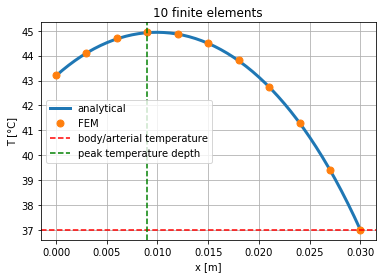

In [53]:
x_anal = np.linspace(0, L, num=T_anal.shape[0])
x = np.linspace(0, L, num=T.shape[0])
plt.plot(x_anal, T_anal, linewidth=3, label='analytical')
plt.plot(x, T, linestyle='None', marker='o', markersize=7, label='FEM')
plt.xlabel('x [m]')
plt.ylabel('T [°C]')
plt.axhline(y=T_c, color='red', linestyle='--', label='body/arterial temperature')
plt.axvline(x=x[np.where(np.max(T)==T)[0]], color='green', linestyle='--', label='peak temperature depth')
plt.grid()
plt.legend(loc='best')
plt.title('{} finite elements'.format(N))
plt.show() 

Data-driven solution of time-independent PDE using Physics-informed Neural Network approach. Instead of dealing with it numerically, the solution is transformed into optimization problem:

$$
k \cdot \frac{d^2 T}{d x^2} - w_b \cdot T(x) + w_b \cdot T_a + Q_m  = 0
$$

$$ \Downarrow $$

$$
J(\theta) = [k \cdot \frac{d^2 \hat{T}}{d x^2} - w_b \cdot \hat T(x) + w_b \cdot T_a + Q_m]^2 + [\hat T(0) - T_0]^2 + [\hat T(L) - T_L]^2
$$

$$
\mbox{Optimization: } \fbox{ $\min_{\theta} J(\theta)$}
$$

where:
* $J(\theta)$ is the cost function;
* $\hat{T}(x)$ is the neural network's output for every input x and
* $T_0$ and $T_L$ are boundary conditions.


Neural network configuration:
* activation: tanh
* initializer: Glorot uniform
* architecture: input (1), 3 hidden (50), output (1)
* optimization: Adam
* metrics: l2 relative error


In [21]:
def pde(x, y):
    dy_x = tf.gradients(y, x)[0]
    dy_xx = tf.gradients(dy_x, x)[0]
    return k*dy_xx - w_b * y + (w_b*T_a + Q_m)

def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

def func(x):
    temp = np.empty(shape=(x.shape[0], 1))
    temp[-1, ] = T_c
    return temp

Building feed-forward neural network...
'build' took 0.050327 s

Compiling model...
'compile' took 0.406529 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.24e+10, 2.50e+05, 1.37e+03]    [1.24e+10, 0.00e+00, 0.00e+00]    [1.00e+00]    
1000      [1.88e+08, 1.86e+05, 9.15e+01]    [1.88e+08, 0.00e+00, 0.00e+00]    [1.25e+01]    
2000      [1.04e+05, 3.12e+05, 2.54e+02]    [1.04e+05, 0.00e+00, 0.00e+00]    [1.42e+01]    
3000      [3.36e+01, 3.16e+05, 2.59e+02]    [3.30e+01, 0.00e+00, 0.00e+00]    [1.43e+01]    
4000      [3.15e+01, 3.16e+05, 2.59e+02]    [3.09e+01, 0.00e+00, 0.00e+00]    [1.43e+01]    
5000      [3.05e+01, 3.16e+05, 2.59e+02]    [3.00e+01, 0.00e+00, 0.00e+00]    [1.43e+01]    
6000      [3.00e+01, 3.16e+05, 2.59e+02]    [2.94e+01, 0.00e+00, 0.00e+00]    [1.43e+01]    
7000      [2.96e+01, 3.16e+05, 2.59e+02]    [2.91e+01, 0.00e+00, 0.00e+00]    [1.43e+01]    
8000   

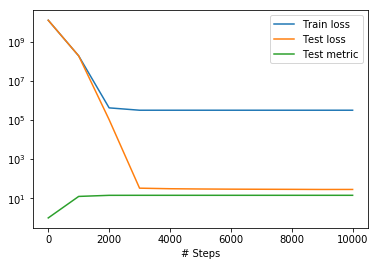

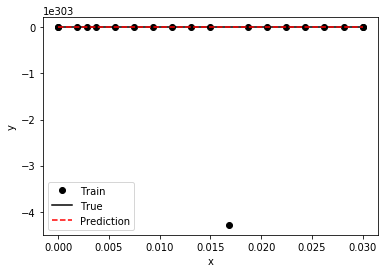

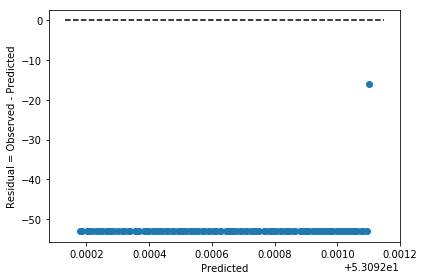

Saving loss history to loss.dat ...
Saving training data to train.dat ...
Saving test data to test.dat ...


In [22]:
geom = dde.geometry.Interval(0, L)
bc_l = dde.RobinBC(geom, lambda X, y: (h_0/k)*y - (h_0*T_f/k), boundary_l)
bc_r = dde.DirichletBC(geom, func, boundary_r)
data = dde.data.PDE(geom, 1, pde, [bc_l, bc_r], 16, 2, func=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)